In [311]:
import pandas as pd
import numpy as np
# csv_files = ['070.csv', '088.csv', '135.csv', '143.csv', '168.csv', '169.csv', '226.csv', '234.csv', '274.csv', '319.csv', '355.csv']

In [312]:
# csv_files = ['003.csv', '064.csv', '070.csv', '088.csv', '135.csv', '143.csv', '168.csv', '169.csv', '213.csv', '226.csv', '228.csv', '230.csv', '234.csv', '274.csv', '319.csv', '355.csv', '367.csv', '374.csv', '376.csv', '387.csv', '390.csv', '405.csv', '416.csv', '433.csv', '436.csv', '445.csv', '473.csv', '484.csv', '495.csv', '528.csv', '542.csv', '546.csv', '552.csv', '558.csv', '559.csv', '577.csv', '592.csv', '614.csv', '640.csv', '645.csv', '653.csv', '662.csv', '665.csv', '702.csv', '791.csv', '804.csv', '859.csv', '875.csv', '914.csv','958.csv']
csv_files = ['003.csv']

In [313]:
# for i in csv_files:
df = pd.read_csv(f'./mine-the-model-2023/Upload-Dataset/TRAIN/{csv_files[0]}').drop(columns=['Dividends','Stock Splits'])
df['Date']=pd.to_datetime(df['Date'])
df = df.reset_index(drop=True)
df.dropna(inplace=True)

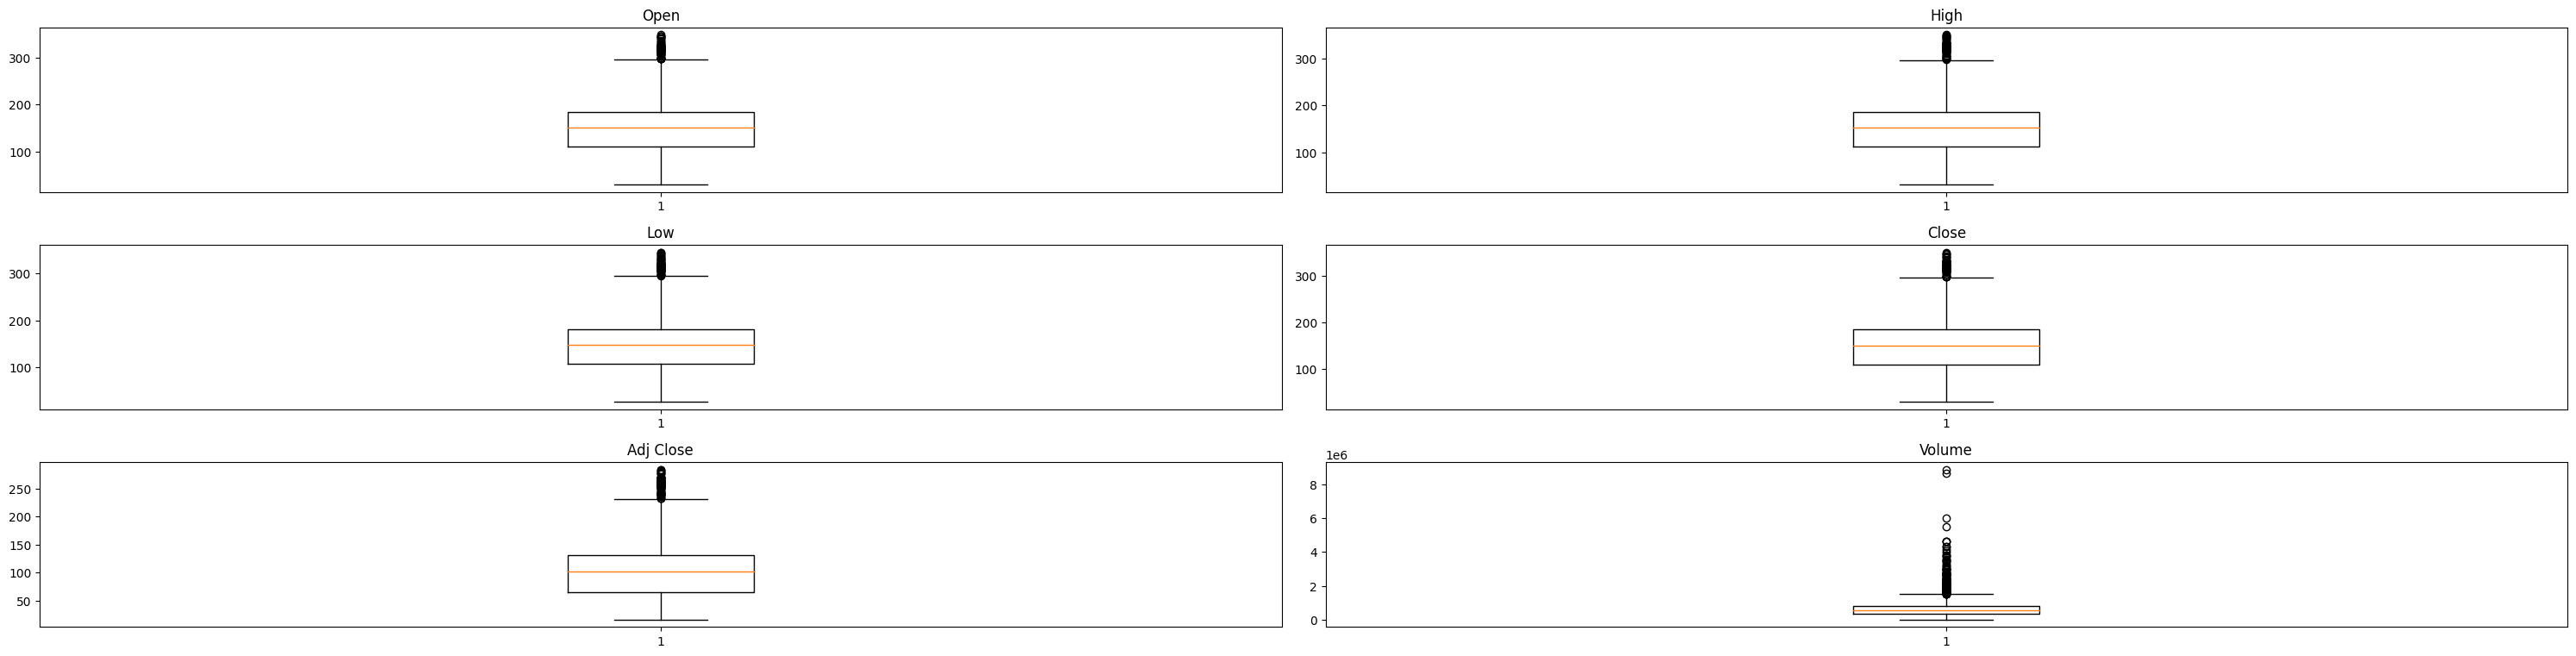

In [314]:
import matplotlib.pyplot as plt

num_columns = len(df.columns)
num_rows = (num_columns + 1) // 2 

fig = plt.figure(figsize=(30, 10))  

for idx, col in enumerate(df.drop(columns=['Date']).columns):
    row = idx // 2
    col_num = idx % 2

    ax = plt.subplot2grid((num_rows, 2), (row, col_num))
    ax.boxplot(df[col])
    ax.set_title(col)

for i in range(num_columns, num_rows * 2):
    fig.delaxes(plt.subplot2grid((num_rows, 2), (i // 2, i % 2)))

plt.tight_layout()
plt.show()

In [315]:
def fix_outliers_iqr(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    dataframe[column] = dataframe[column].apply(lambda x: lower_limit if x < lower_limit else upper_limit if x > upper_limit else x)
    
for column in df.drop(columns=['Date']).columns:
    fix_outliers_iqr(df, column)

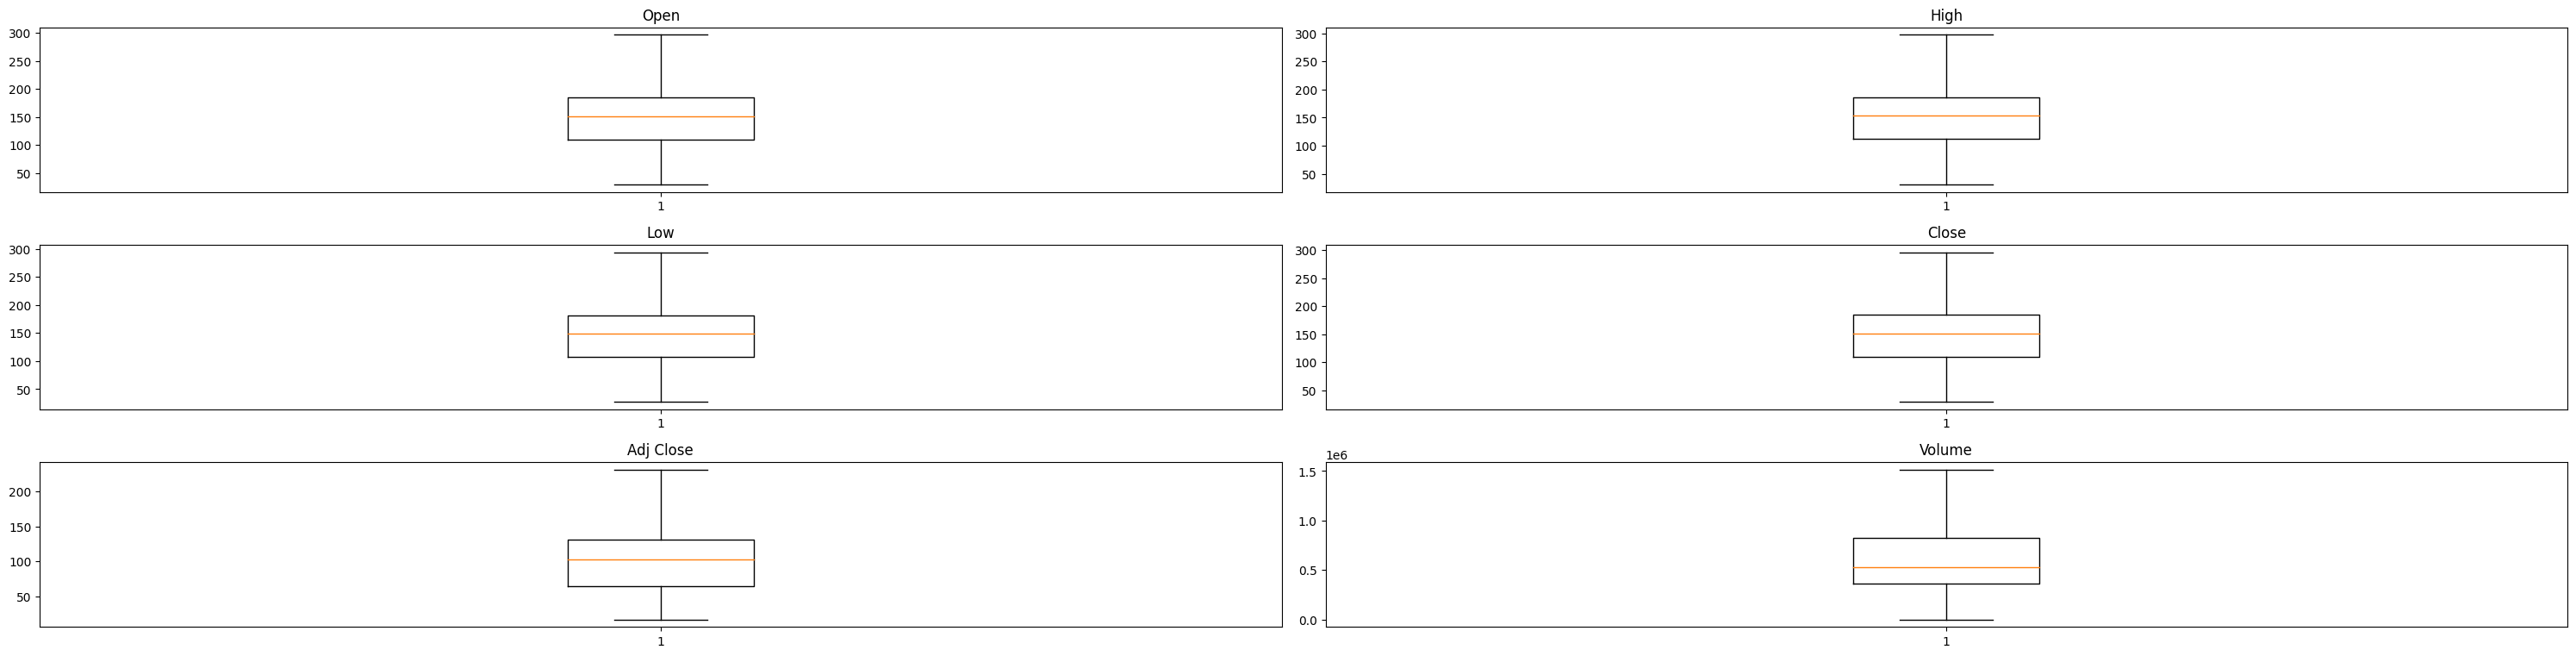

In [316]:
import matplotlib.pyplot as plt

num_columns = len(df.columns)
num_rows = (num_columns + 1) // 2 

fig = plt.figure(figsize=(30, 10))  

for idx, col in enumerate(df.drop(columns=['Date']).columns):
    row = idx // 2
    col_num = idx % 2

    ax = plt.subplot2grid((num_rows, 2), (row, col_num))
    ax.boxplot(df[col])
    ax.set_title(col)

for i in range(num_columns, num_rows * 2):
    fig.delaxes(plt.subplot2grid((num_rows, 2), (i // 2, i % 2)))

plt.tight_layout()
plt.show()

In [317]:
df.corr()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,1.000000,0.776950,0.779029,0.775756,0.777512,0.862135,-0.570867
Open,0.776950,1.000000,0.999252,0.999290,0.998532,0.980508,-0.499258
High,0.779029,0.999252,1.000000,0.999087,0.999262,0.981607,-0.492087
Low,0.775756,0.999290,0.999087,1.000000,0.999364,0.980917,-0.506441
Close,0.777512,0.998532,0.999262,0.999364,1.000000,0.981794,-0.499472
Adj Close,0.862135,0.980508,0.981607,0.980917,0.981794,1.000000,-0.516964
Volume,-0.570867,-0.499258,-0.492087,-0.506441,-0.499472,-0.516964,1.000000


# Neural Net Using TensorFlow

### Moving average logic
1. Ex: Based on first 10 days we predict 11th day

In [318]:
ma_100_days = df['Close'].rolling(100).mean()

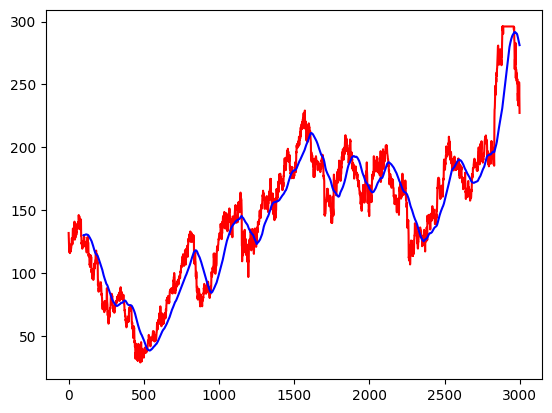

In [319]:
plt.plot(df['Close'],c='r')
plt.plot(ma_100_days,c='b')

### Split

In [320]:
from sklearn.preprocessing import MinMaxScaler
mx = MinMaxScaler(feature_range=(0,1))
Close = mx.fit_transform(np.array(df['Close']).reshape(-1,1))

In [321]:
split_ratio = 0.8 
split_index = int(split_ratio * len(df))

xtrain = pd.DataFrame(Close[:split_index])
xtest = pd.DataFrame(Close[split_index:])
xtest.tail()

,0
595,0.791048
596,0.834121
597,0.824758
598,0.789925
599,0.742731


### Scaling

In [322]:
# from sklearn.preprocessing import MinMaxScaler
# mx = MinMaxScaler(feature_range=(0,1))
# xtrain_trf = mx.fit_transform(xtrain)


### Ex : data = 1,2,3,4,5,6,7,8,9,10,11,12
1. lets say rolling avg = 10 
2. prediction of day 1 == done by 1 to 10 
3. prediction day 2 done by 2 to 11 

In [323]:
x = []
y = []
for i in range(100, xtrain.values.shape[0]):
    x.append(xtrain.values[i - 100:i])
    y.append(xtrain.values[i,0])

x,y = np.array(x),np.array(y)
y.shape

(2300,)

# Keras LSTM

1. Creating Layers : we create 4 layers 
2. units = no. of neurons in each layer
3. Return Sequence: o/p of one layer become i/p of next
4. activation : Relu =>  rectified Linear Unit : intoduce non-lin to DL solving vanishing GD :: similar to sigmoid
5. DropOut: Loss to decrease overfit :: 0.2 = 20%
6. Dense = 1 as only 1 o/p

In [324]:
from keras.layers import Dense,Dropout,LSTM
from keras.models import Sequential
import tensorflow as tf

In [325]:
# !pip install tensorflow

In [326]:
model = Sequential()
# Layers
model.add(LSTM(units=50,activation='relu',return_sequences=True,input_shape = ((x.shape[1],1))))
model.add(Dropout(0.2))

model.add(LSTM(units=60,activation='relu',return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=80,activation='relu',return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units=120,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1))

In [327]:
model.compile(optimizer="adam",loss="mean_squared_error")

In [328]:
model.fit(x,y,epochs=1,batch_size=32,verbose=1)

72/72 [==============================] - 15s 155ms/step - loss: 0.0310


In [329]:
xtest_trf = xtest
xtest.shape

(600, 1)

In [331]:
x1 = np.array([xtest_trf[-100:]])
# xtest_trf = np.vstack((xtest_trf,2))
# x1 = np.array([xtest_trf[-100:]])
for i in range(100):
    pred = model.predict(np.array([xtest[-100:]]))
    print(pred * (1/mx.scale_))
    xtest = np.append(xtest,pred,axis=0)

1/1 [==============================] - 2s 2s/step
[[237.86227557]]
1/1 [==============================] - 0s 40ms/step
[[236.0401097]]
1/1 [==============================] - 0s 40ms/step
[[234.37456643]]
1/1 [==============================] - 0s 40ms/step
[[232.89674111]]
1/1 [==============================] - 0s 41ms/step
[[231.62915161]]
1/1 [==============================] - 0s 41ms/step
[[230.58374914]]
1/1 [==============================] - 0s 42ms/step
[[229.76215687]]
1/1 [==============================] - 0s 45ms/step
[[229.1567999]]
1/1 [==============================] - 0s 43ms/step
[[228.75300579]]
1/1 [==============================] - 0s 38ms/step
[[228.53134393]]
1/1 [==============================] - 0s 39ms/step
[[228.46931234]]
1/1 [==============================] - 0s 40ms/step
[[228.54354973]]
1/1 [==============================] - 0s 42ms/step
[[228.73107672]]
1/1 [==============================] - 0s 46ms/step
[[229.00999606]]
1/1 [==============================] -

In [ ]:
y_pred = model.predict(x1)

1/1 [==============================] - 0s 54ms/step


In [ ]:
xtest_trf = np.append(xtest_trf,y_pred,axis=0)
x1 = np.array([xtest_trf[-100:]])
y_pred = model.predict(x1)
y_pred

1/1 [==============================] - 0s 51ms/step


array([[0.80134547]], dtype=float32)

# Values are scaled Now take them back to original values

In [ ]:
xtest_trf = np.append(xtest_trf,y_pred,axis=0)
xtest_trf[-10:]

array([[0.78917552],
       [0.79217192],
       [0.78730277],
       [0.79441919],
       [0.79104827],
       [0.83412144],
       [0.82475771],
       [0.78992461],
       [0.74273136],
       [0.82820171]])

In [ ]:
model.predict(np.array([xtest_trf[-100:]]))

1/1 [==============================] - 0s 41ms/step


array([[0.82183343]], dtype=float32)

In [ ]:
scale = 1/mx.scale_
xtest_trf[-10:]*scale

array([[210.70000267],
       [211.50000572],
       [210.20000267],
       [212.09999657],
       [211.20000267],
       [222.70000267],
       [220.20000267],
       [210.89999962],
       [198.29999352],
       [221.11950847]])

In [ ]:
y_pred = y_pred*scale
y_pred.reshape((1,y_pred.shape[0])).ravel()[-100:]
y_pred[0]

array([221.11950847])

In [ ]:
y1 = y1 * scale

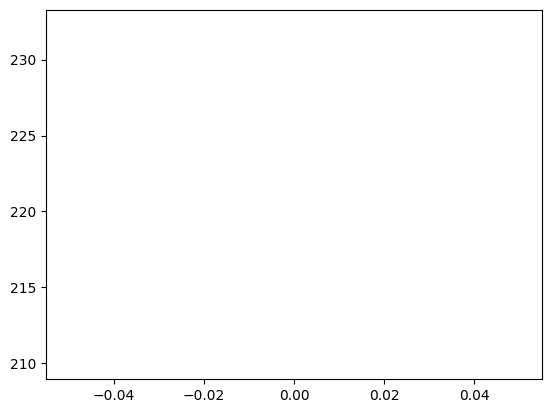

In [ ]:
plt.plot(y_pred, 'r', label = 'Predicted Price')
plt.plot(y1, 'g', label = 'Original Price')